<a href="https://colab.research.google.com/github/emilchafigoulline/Data-Science/blob/main/Unit2/EmilChafU2Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: S&P 500
In this project, I will be modeling the probability of an increase in the S&P 500 stock index on a given month. The S&P 500 is an index composed of the market values of the top 500 companies listed for trading in the U.S. trade market. It's generally an accurate reflection of the general strength of the market. As such, I'm interested in using data to predict the future growth of the index.

In [ ]:
import pymc as pm #importing neccessary libraries
import numpy as np
import pandas as pd
!pip install preliz

In [ ]:
import preliz as pz
import arviz as az

# Prior and Likelihood
To first model the S&P 500 stock index, I will create a prior based on my previous limited knowledge of the behavior of the index. As such, I'm assuming the index increases approximately 51% of the time. I'll then count up the number of rises and falls on a given month for the past 500 months of the index, helping me form my likelihood. In this section, I chose to weight my prior as 10% of my data. While I am fairly confident that the S&P 500 increases at about 51% per month, I am not certain, and so I used a prior that would have a significant influence on the data, but not an overwhelming one.

318
181


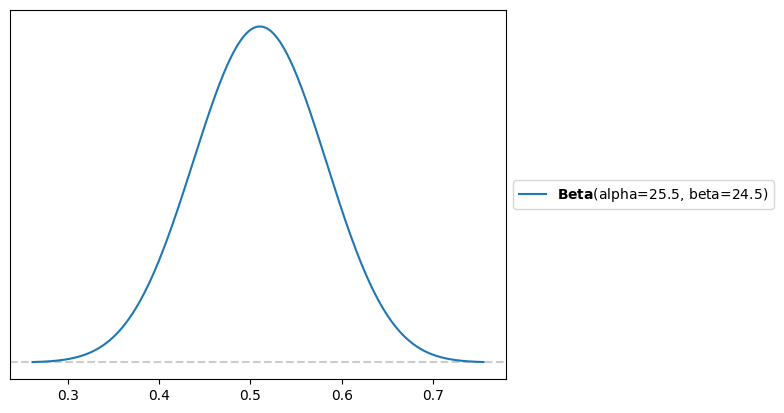

In [ ]:
snp_prior = pz.Beta(alpha = 25.5, beta = 24.5) #defining prior model
snp_prior_mode = (snp_prior.alpha -1)/(snp_prior.alpha + snp_prior.beta -2)
snp_prior.median(), snp_prior.mean(), snp_prior_mode #forming the prior model and defining it
data = pd.read_csv("https://raw.githubusercontent.com/emilchafigoulline/Data-Science/refs/heads/main/S%26P%20Return%20Positive_Negative%20-%20Sheet1-1%20-%20Sheet1.csv")
#data imported; code from notes
df = data['Delta']
rise = 0 #buckets
fall = 0
df_int = pd.to_numeric(df, errors="coerce") #scans through dataset(binary) to find number of rises and falls
for i in range(len(df_int)):
  if df_int.iloc[i] > 0.5:
    rise += 1
  else:
    if df_int.iloc[i] < 0.5:
      fall += 1
    else:
      break
print(rise) #goes into bucket
print(fall)


In this section, I will use the formula for an analytic Beta distrubtion
$p(θ|y) ∝ p(y|θ)p(θ) = Beta(α_{new}=α+k,β_{new}=n-k+β)$ (Arredondo)
to plot my prior with my data.


(np.float64(0.6245454545454545), 0.6246965223806851, np.float64(0.625))

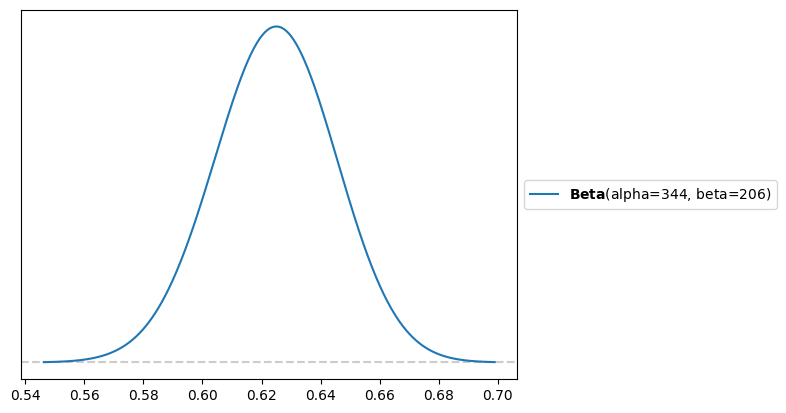

In [ ]:
alpha_old = 25.5
beta_old = 24.5
k = 318
n = 500
analytic_model = pz.Beta(alpha = alpha_old + k, beta = beta_old + n -k)
analytic_model.plot_pdf()
analytic_model.mean(), analytic_model.median(), analytic_model.mode()

This is our analytic mode, created with the formula for a beta distribution created from our prior and data. In this model, we can see that our mean is around 0.62454545, and our median is 0.624696, meaning that my model is very slightly skewed left. This model shows that we should expect the S&P 500 to increase 62.45% of the time.

# Posterior and PYMC Model

In [ ]:
stock_rises = np.repeat(1,318) #set the data for likelihood
stock_falls = np.repeat(0,181)
stock_data = np.concatenate([stock_rises,stock_falls]) #formats ups and downs into a single dataset

In [ ]:
with pm.Model() as stock_data_model:
  θ = pm.Beta('θ', alpha = 25.5, beta = 24.5)#defining prior model

  y = pm.Bernoulli('y', p = θ, observed = stock_data)#defining likelihood

  idata_stock = pm.sample(1000) #here, we draw 1000 samples from our model to form a distrubution.

In [ ]:
import arviz as az

<Axes: title={'center': 'θ'}>

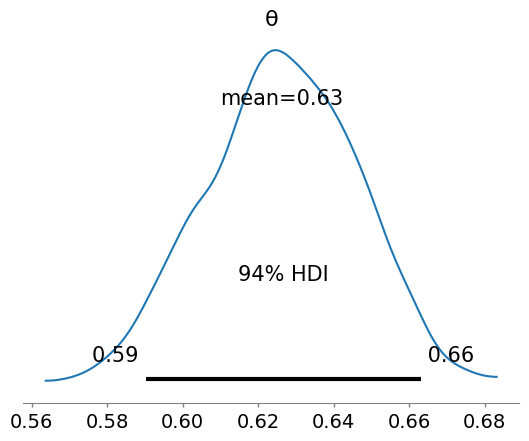

In [ ]:
az.plot_posterior(idata_stock) #plot our posterior based on the data we have

Based on our created model, we can see that our mean is 0.63 and our HDI is 94%. This indicates that the mean increase for our model is 63% of the time, meaning we should expect the S&P 500 to increase 63/100 months. Meanwhile, our 94% HDI indicates that we would expect to be 94% confident the real mean of our dataset is between 0.59 and 0.66. My posterior mean of 0.63 is quite different from the prior assumption of an S&P increase of 0.51. This indicates that while my current knowledge might be plausible for a more recent model, it isn't accurate for a long-term prediction of the S&P 500. I believe that my model is accurate for predicting the real-world. With further research, it is indicated that the S&P 500 increases about 0.59 of the time per month, which is a plausible number for my model to produce. However, my mean could be slightly higher than the average for a longer period of time due to greater increase in the 40 years my data is pulled from.

In [ ]:
pm.sample_posterior_predictive(idata_stock, model = stock_data_model, extend_inferencedata = True)
#drawing from our posterior samples and comparing them to the model
stacked_stock = az.extract(idata_stock, group= "posterior_predictive")

In [ ]:
#idata_FT_2324.posterior_predictive.y.to_series().values
stacked_stock.sel(sample=0).sel(draw=0).y.to_series().values

array([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

And by using forming the posterior predictive for our model of the S&P 500, we have obtained a prediction for the next 500 months, where 1 indicates a rise in the index and a 0 indicates a fall. Our model indicates that over the next 500 months, the S&P 500 will increase 292 months. While this matches my analytic and my pymc model, this is not the result I expected considering my prior, which estimated an increase rate of 51%. This is likely because, when taking the data, which consists of the last 500 months of the S&P 500, it was skewed towards increasing due to the market having high volatility and increasing during this time period.